In [1]:
# pymc3がない人はコメントアウト
import numpy as np
import pymc3 as pm3
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize

/Users/haya/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# データセットの作成

MU = 10.0
SIGMA = 1.0

y0 = np.random.normal(MU, SIGMA, size=10) 
y1 = np.random.normal(MU, SIGMA, size=100)
y2 = np.random.normal(MU, SIGMA, size=1000)
y3 = np.random.normal(MU, SIGMA, size=10000)
y = [y0, y1, y2, y3]

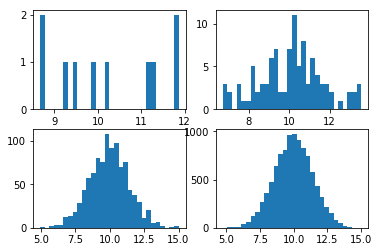

In [3]:
# 可視化

fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.hist(y[i], bins=30)
plt.show()

In [4]:
# GLMでのモデリング（ただの最尤推定）
for i in [1, 2, 3, 4]:
    size = 10**i
    x = [1 for j in range(size)]
    glm = sm.GLM(np.array(y[i - 1]), np.array(x), family=sm.families.Gaussian())
    res = glm.fit()
    print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   10
Model:                            GLM   Df Residuals:                        9
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                   1.46153482988
Method:                          IRLS   Log-Likelihood:                -15.560
Date:                Wed, 27 Sep 2017   Deviance:                       13.154
Time:                        11:20:37   Pearson chi2:                     13.2
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2356      0.382     26.774      0.000       9.486      10.985
                 Generalized Linear Model Regression

Optimization terminated successfully.
         Current function value: 17668.193642
         Iterations: 3
         Function evaluations: 79


100%|██████████| 5000/5000 [00:01<00:00, 2506.94it/s]


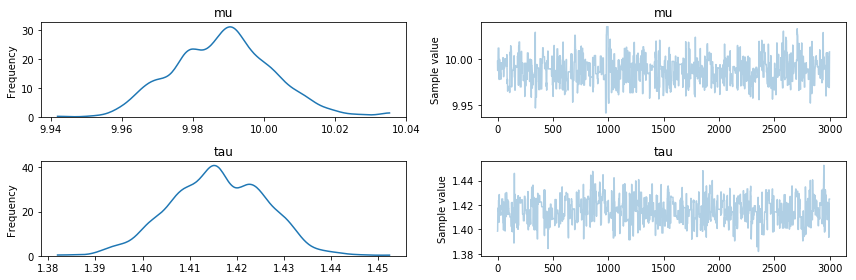


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.988            0.014            0.001            [9.962, 10.015]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.963          9.978          9.989          9.998          10.017


tau:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.416            0.010            0.000            [1.396, 1.433]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.396          1.409          1.416          1.423          1.434



In [6]:
# pymc3のコード

with pm3.Model() as model:
    mu = pm3.Uniform("mu", upper= 10**2, lower= -(10**2))
    tau = pm3.Uniform("tau", upper= 10**2, lower= 0)
    Y_obs = pm3.Normal("Y_obs", mu=mu, sd=tau, observed=np.array(y3)) #ここのyを書き換えてください
    
with model:
    start = pm3.find_MAP(fmin=optimize.fmin_powell)
    step = pm3.Metropolis()
    trace = pm3.sample(5000, start=start, step=step)
    pm3.traceplot(trace[2000:])
    plt.show()
    pm3.summary(trace[2000:])

In [44]:
# pymcのコード

mu = pm.Uniform("mu", upper= 10**2, lower= -(10**2))
tau = pm.Uniform("tau", upper= 10**2, lower= 0)
obs = pm.Normal("obs", mu=mu, tau=tau, value=y3, observed=True)
model = pm.Model([obs, mu, tau])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(5000, 2000)

 [-----------------100%-----------------] 5000 of 5000 complete in 2.3 sec

Plotting mu
Plotting tau


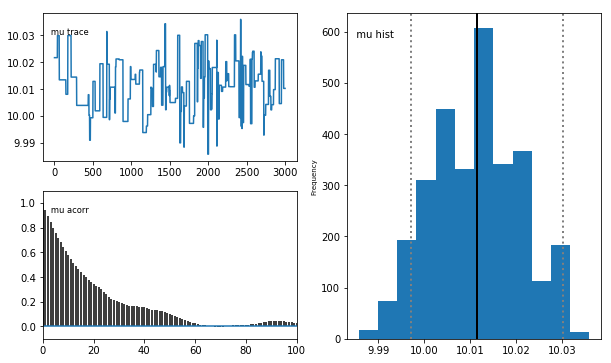

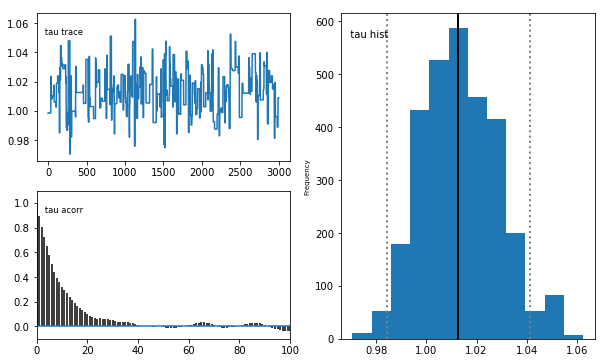

In [46]:
plt.close()
pm.Matplot.plot(mcmc.trace("mu"), common_scale=False)
pm.Matplot.plot(mcmc.trace("tau"), common_scale=False)
plt.show()